#Lab 1 Fine-tuning

Завантажимо Intel Image Classification із Kaggle за допомогою офіційного Kaggle API

In [ ]:
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()  # оберіть ваш kaggle.json

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d puneet6060/intel-image-classification

Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 91% 316M/346M [00:03<00:00, 66.3MB/s]
100% 346M/346M [00:03<00:00, 100MB/s] 


In [ ]:
!unzip intel-image-classification.zip -d intel_data

Показано результат, скорочений до останніх рядків (5000).
  inflating: intel_data/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/767.jpg  
  inflating: intel_data/seg_train/seg_train/mou

Перевіримо структуру

In [ ]:
!find intel_data -maxdepth 2 -type d

intel_data
intel_data/seg_pred
intel_data/seg_pred/seg_pred
intel_data/seg_test
intel_data/seg_test/seg_test
intel_data/seg_train
intel_data/seg_train/seg_train


Проаналізуємо баланс класів у тренувальному та тестовому наборі та подивимось кілька випадкових прикладів.

Train set:
  buildings: 2191
  forest: 2271
  glacier: 2404
  mountain: 2512
  sea: 2274
  street: 2382

Test set:
  buildings: 437
  forest: 474
  glacier: 553
  mountain: 525
  sea: 510
  street: 501


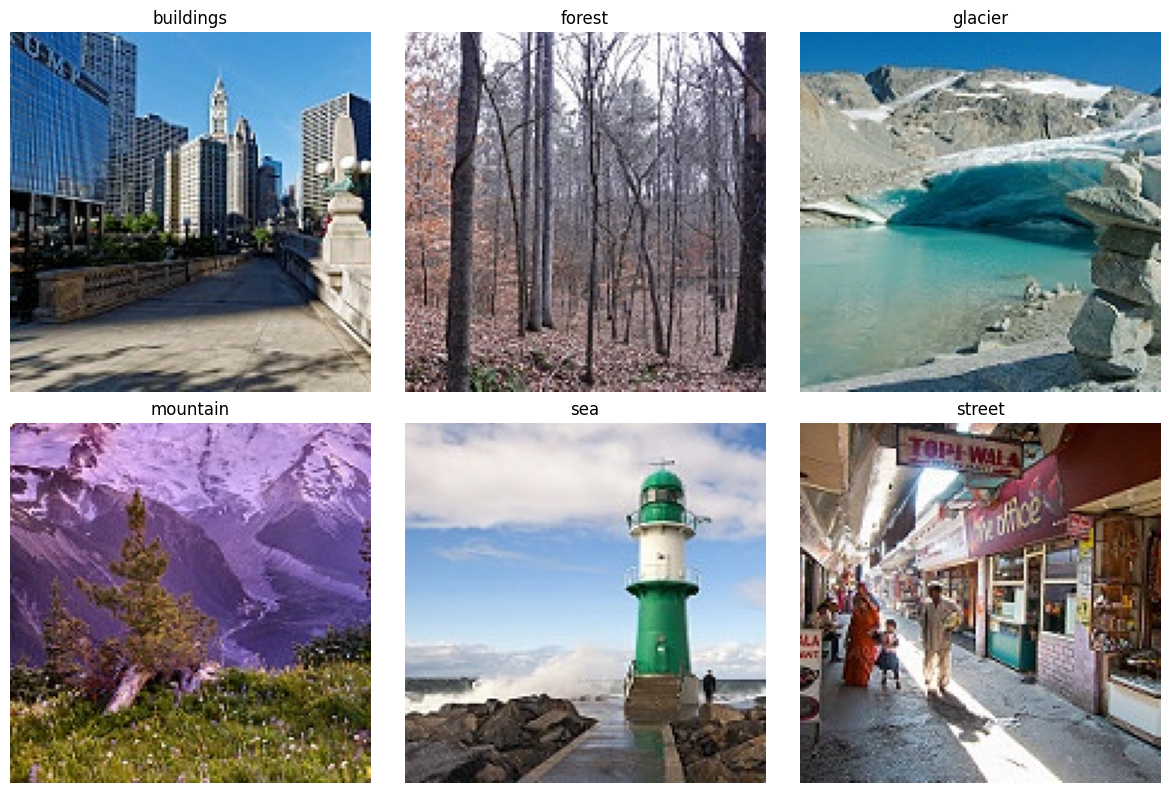

In [ ]:
import os
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import random

# Шлях до тренувальних і тестових даних
train_dir = 'intel_data/seg_train/seg_train'
test_dir  = 'intel_data/seg_test/seg_test'

# Функція підрахунку зображень по класах
def count_images(path):
    counts = {}
    for cls in sorted(os.listdir(path)):
        cls_path = os.path.join(path, cls)
        if os.path.isdir(cls_path):
            counts[cls] = len([f for f in os.listdir(cls_path)
                               if os.path.isfile(os.path.join(cls_path,f))])
    return counts

train_counts = count_images(train_dir)
test_counts  = count_images(test_dir)

print("Train set:")
for cls, cnt in train_counts.items():
    print(f"  {cls}: {cnt}")
print("\nTest set:")
for cls, cnt in test_counts.items():
    print(f"  {cls}: {cnt}")

# Візуалізація по одному прикладу з кожного класу
classes = list(train_counts.keys())
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for ax, cls in zip(axes.flatten(), classes):
    img_name = random.choice(os.listdir(os.path.join(train_dir, cls)))
    img = Image.open(os.path.join(train_dir, cls, img_name))
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')
plt.tight_layout()
plt.show()

Розподіл по класах досить рівномірний (мінімальна кількість 2 191, максимальна 2 512 — різниця менше ніж 15 %). Значного дисбалансу немає, тому перейдемо відразу до аугментації для покращення узагальнення.

In [ ]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Шляхи
train_dir = 'intel_data/seg_train/seg_train'
test_dir  = 'intel_data/seg_test/seg_test'

# Трансформації для тренувальної вибірки (із аугментацією)
train_transforms = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])

# Трансформації для тестової (без аугментації)
test_transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225])
])

# Створення Dataset та DataLoader
train_dataset = ImageFolder(train_dir, transform=train_transforms)
test_dataset  = ImageFolder(test_dir,  transform=test_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)

Resize приводить усі зображення до 224×224.

RandomHorizontalFlip і RandomRotation додають варіації.

ColorJitter коригує яскравість/контраст/насиченість.

Normalize — стандартні ImageNet-параметри.

Далі переходимо до вибору та налаштування базової моделі — візьмемо ResNet-50 із попереднім навчанням на ImageNet і адаптуємо під 6 класів Intel Dataset.

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Вибір пристрою
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Завантажуємо ResNet50 з pre-trained вагами
model = models.resnet50(pretrained=True)

# Замінюємо останній FC-шар на новий для 6 класів
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)

model = model.to(device)

# --- Варіант A: тренуємо тільки новий FC-шар (freeze backbone) ---
for name, param in model.named_parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# --- Варіант B: тонко донавчання всіх шарів (unfreeze всі) ---
# for param in model.parameters():
#     param.requires_grad = True

# Визначаємо функцію втрат і оптимізатор
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=1e-3
)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


Спочатку зробимо baseline із «замороженим» backbone (варіант A) — тренуватимемо тільки замінений FC-шар протягом кількох епох і подивимось, який результат він дає.

Ваги ResNet-50 успішно завантажені. Тепер запускаємо baseline-тренування «замороженого» backbone (тренуємо тільки FC-шар).

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights

# Завантажуємо модель з актуальними вагами
model = resnet50(weights=ResNet50_Weights.DEFAULT)
# Замінюємо фінальний шар
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 6)
model = model.to(device)

# Freeze backbone
for name, param in model.named_parameters():
    param.requires_grad = False
for param in model.fc.parameters():
    param.requires_grad = True

# Перевизначаємо оптимізатор
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 104MB/s]


In [ ]:
import time
from sklearn.metrics import accuracy_score

# Параметри
num_epochs = 5

# Функція тренування/валідації за одну епоху
def train_validate(model, train_loader, test_loader, criterion, optimizer, device):
    # Тренування
    model.train()
    train_losses, train_preds, train_labels = [], [], []
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        train_preds.extend(outputs.argmax(1).cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

    # Валідація
    model.eval()
    val_losses, val_preds, val_labels = [], [], []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_losses.append(loss.item())
            val_preds.extend(outputs.argmax(1).cpu().numpy())
            val_labels.extend(labels.cpu().numpy())

    train_acc = accuracy_score(train_labels, train_preds)
    val_acc   = accuracy_score(val_labels,   val_preds)
    return (sum(train_losses)/len(train_losses), train_acc,
            sum(val_losses)/len(val_losses),     val_acc)

# Основний цикл тренування
for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc, val_loss, val_acc = train_validate(
        model, train_loader, test_loader, criterion, optimizer, device
    )
    elapsed = time.time() - start

    print(f"Epoch {epoch:02d} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

Epoch 01 | Train loss: 0.5185, acc: 0.8442 | Val loss: 0.3167, acc: 0.8890 | Time: 115.7s
Epoch 02 | Train loss: 0.3173, acc: 0.8923 | Val loss: 0.2855, acc: 0.8987 | Time: 114.4s
Epoch 03 | Train loss: 0.2937, acc: 0.8974 | Val loss: 0.2618, acc: 0.9043 | Time: 113.5s
Epoch 04 | Train loss: 0.2737, acc: 0.9029 | Val loss: 0.2435, acc: 0.9170 | Time: 113.8s
Epoch 05 | Train loss: 0.2623, acc: 0.9078 | Val loss: 0.2400, acc: 0.9140 | Time: 113.9s


Отримали результат для frozen-backbone! Тепер зробимо повний fine-tuning усієї мережі — розморозимо весь ResNet-50, зменшимо швидкість навчання і подивимося, як покращаться метрики.

Розморожування дає змогу підлаштувати всі шари під наш датасет.

lr=1e-4 — зазвичай підходить для тонкого донавчання великих мереж.

Після запуску отримаємо нові train/val accuracy та loss, порівняємо з baseline (91.4 % на валідації).

In [ ]:
# 1) Розморожуємо всі шари
for param in model.parameters():
    param.requires_grad = True

# 2) Перевизначаємо оптимізатор з меншим lr
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# (За бажанням можна додати scheduler, наприклад)
# from torch.optim.lr_scheduler import StepLR
# scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# 3) Запускаємо ще 5 епох fine-tuning
num_epochs = 5
for epoch in range(1, num_epochs+1):
    start = time.time()
    train_loss, train_acc, val_loss, val_acc = train_validate(
        model, train_loader, test_loader, criterion, optimizer, device
    )
    # scheduler.step()  # якщо використовуєте scheduler
    elapsed = time.time() - start

    print(f"Fine-tune Epoch {epoch:02d} | "
          f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | "
          f"Val loss: {val_loss:.4f}, acc: {val_acc:.4f} | "
          f"Time: {elapsed:.1f}s")

Fine-tune Epoch 01 | Train loss: 0.2203, acc: 0.9203 | Val loss: 0.1754, acc: 0.9347 | Time: 151.6s
Fine-tune Epoch 02 | Train loss: 0.1485, acc: 0.9443 | Val loss: 0.1744, acc: 0.9377 | Time: 151.5s
Fine-tune Epoch 03 | Train loss: 0.1085, acc: 0.9582 | Val loss: 0.1791, acc: 0.9340 | Time: 152.5s
Fine-tune Epoch 04 | Train loss: 0.0878, acc: 0.9679 | Val loss: 0.2140, acc: 0.9257 | Time: 151.6s
Fine-tune Epoch 05 | Train loss: 0.0655, acc: 0.9774 | Val loss: 0.2047, acc: 0.9353 | Time: 152.7s


Візуалізуємо результати.

,epoch,baseline_train_loss,baseline_train_acc,baseline_val_loss,baseline_val_acc,finetune_train_loss,finetune_train_acc,finetune_val_loss,finetune_val_acc
0,1,0.5185,0.8442,0.3167,0.8890,0.2203,0.9203,0.1754,0.9347
1,2,0.3173,0.8923,0.2855,0.8987,0.1485,0.9443,0.1744,0.9377
2,3,0.2937,0.8974,0.2618,0.9043,0.1085,0.9582,0.1791,0.9340
3,4,0.2737,0.9029,0.2435,0.9170,0.0878,0.9679,0.2140,0.9257
4,5,0.2623,0.9078,0.2400,0.9140,0.0655,0.9774,0.2047,0.9353


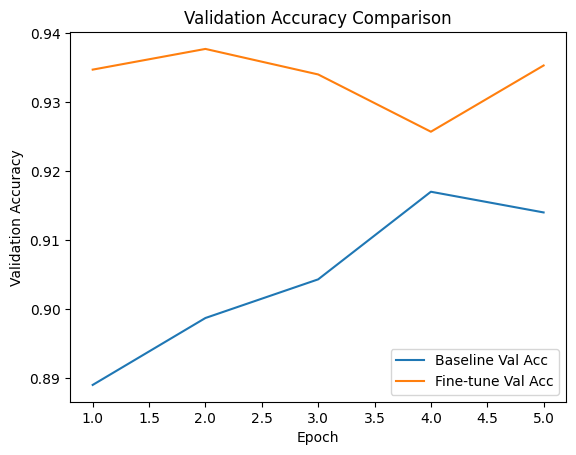

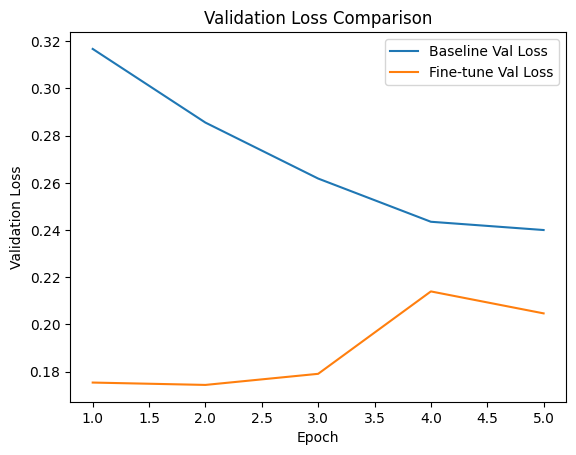

In [ ]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

# Metrics from baseline and fine-tuning
metrics = {
    'epoch': [1, 2, 3, 4, 5],
    'baseline_train_loss': [0.5185, 0.3173, 0.2937, 0.2737, 0.2623],
    'baseline_train_acc': [0.8442, 0.8923, 0.8974, 0.9029, 0.9078],
    'baseline_val_loss': [0.3167, 0.2855, 0.2618, 0.2435, 0.2400],
    'baseline_val_acc': [0.8890, 0.8987, 0.9043, 0.9170, 0.9140],
    'finetune_train_loss': [0.2203, 0.1485, 0.1085, 0.0878, 0.0655],
    'finetune_train_acc': [0.9203, 0.9443, 0.9582, 0.9679, 0.9774],
    'finetune_val_loss': [0.1754, 0.1744, 0.1791, 0.2140, 0.2047],
    'finetune_val_acc': [0.9347, 0.9377, 0.9340, 0.9257, 0.9353]
}

# 1) Створюємо DataFrame і відображаємо його
df = pd.DataFrame(metrics)
display(df)

# 2) Графік порівняння валідаційної точності
plt.figure()
plt.plot(df['epoch'], df['baseline_val_acc'], label='Baseline Val Acc')
plt.plot(df['epoch'], df['finetune_val_acc'], label='Fine-tune Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy Comparison')
plt.legend()
plt.show()

# 3) Графік порівняння валідаційної втрати
plt.figure()
plt.plot(df['epoch'], df['baseline_val_loss'], label='Baseline Val Loss')
plt.plot(df['epoch'], df['finetune_val_loss'], label='Fine-tune Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.show()

На основі отриманих метрик і графіків:

Baseline (freeze-backbone)

Валідальна точність зросла з 88.9 % до максимуму 91.7 % (епоха 4), завершивши на 91.4 %.

Валідальна втрата стабільно знижувалась від 0.317 до 0.240.

Fine-tuning (анфріз усіх шарів)

Валідальна точність стартувала з 93.5 %, досягла піку 93.8 % в епосі 2 і залишалась стабільно вище 92.5 %.

Валідальна втрата спочатку знизилась до 0.175, але з епохи 4 трохи зросла до 0.214, що може свідчити про початок легкого перенавчання.

Порівняння

Fine-tuning дав приріст ≈2.0–2.5 % у валідаційній точності порівняно з baseline.

Валідальні втрати впали майже удвічі (0.24 → ~0.18) уже в перших двох епохах тонкого донавчання.

Легкий підйом валідаційної втрати після епохи 3 вказує на можливість зупинити тренування раніше (early stopping) або знизити learning rate ще сильніше.

Висновки й рекомендації

Fine-tuning усього ResNet-50 суттєво покращив результати на Intel Image Classification.

Щоб уникнути перенавчання, варто:

Застосувати scheduler (знижувати lr кожні кілька епох).

Використати early stopping на показниках валідації.

Спробувати регулізацію (weight decay, dropout).

У підсумку тонке донавчання адаптувало мережу до специфіки датасету й суттєво підвищило якість класифікації.

Таким чином завдання fine-tuning виконане: ми обрали нерекурсивний датасет, підібрали архітектуру (ResNet-50), застосували різні стратегії донавчання і порівняли результати з базовими.